# Unit 5 - Financial Planning

In [2]:
# Initial imports
import os
import requests
import pandas as pd
from datetime import datetime
from datetime import timedelta
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [4]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [6]:
# Fetch current BTC price
btc_value = requests.get(btc_url)
btc_value = btc_value.json()['data']['1']['quotes']['CAD']['price']

# Fetch current ETH price
eth_value = requests.get(eth_url)
eth_value = eth_value.json()['data']['1027']['quotes']['CAD']['price']


# Compute current value of my crpto
my_btc_value = btc_value * my_btc
my_eth_value = eth_value * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $65941.87
The current value of your 5.3 ETH is $20560.30


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [7]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(alpaca_api_key,alpaca_secret_key,api_version='v2')
# alpaca.get_account()

In [9]:
# Format current date as ISO format
# Date is set to -1 due to alpaca account limits
today = datetime.today() - timedelta(days=1)
today = today.strftime('%Y-%m-%d')
today

#supplied end date instead of limit = 1000 parameter
past = datetime.today() - timedelta(days=1000)
past = past.strftime('%Y-%m-%d')
past

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data). This was not used, start date provided instead
data_bar_df = alpaca.get_bars(tickers,TimeFrame(1,TimeFrameUnit.Day),past,today,adjustment='raw').df
data_bar_df.index = data_bar_df.index.date
data_bar_df = data_bar_df[['close','symbol']]

# Preview DataFrame
data_bar_df

,close,symbol
2019-06-28,111.35,AGG
2019-07-01,111.18,AGG
2019-07-02,111.38,AGG
2019-07-03,111.56,AGG
2019-07-05,111.09,AGG
...,...,...
2022-03-17,441.07,SPY
2022-03-18,444.31,SPY
2022-03-21,444.30,SPY
2022-03-22,449.59,SPY


In [10]:
# Pick AGG and SPY close prices
closing = pd.pivot_table(data_bar_df,values='close',index=[data_bar_df.index],columns=['symbol'])
agg_close_price = closing.iloc[-1]['AGG']
spy_close_price = closing.iloc[-1]['SPY']

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.19
Current SPY closing price: $443.8


In [11]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22190.00
The current value of your 200 AGG shares is $21438.00


### Savings Health Analysis

In [12]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
financials = [['crypto',my_btc_value + my_eth_value],['shares',my_agg_value+my_spy_value]]

# Create savings DataFrame
df_savings = pd.DataFrame(financials,columns=['assets','amount'])
df_savings.set_index('assets', drop = True, inplace = True)
 
# Display savings DataFrame
display(df_savings)

,amount
assets,
crypto,86502.17606
shares,43628.00000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

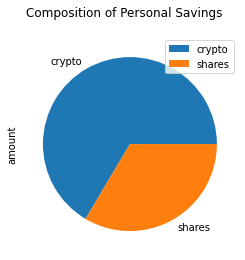

In [13]:
# Plot savings pie chart
df_savings.plot(kind='pie',y='amount',subplots=True,title='Composition of Personal Savings')

In [14]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = my_agg_value+my_btc_value+my_eth_value+my_spy_value

# Validate saving health
if savings > emergency_fund:
    print('Congratulations! You have enough money in your emergency fund.')
elif savings <= emergency_fund:
    print('Warning! You do not have enough money in your emergency fund')

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [17]:
# Ignored due to change in API
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
# start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
# end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

#supplied five year date instead of limit parameter
five_year = datetime.today() - timedelta(weeks=5*52)
five_year = five_year.strftime('%Y-%m-%d')
five_year


'2017-03-30'

In [211]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = alpaca.get_bars(tickers,TimeFrame(1,TimeFrameUnit.Day),five_year,today,adjustment='raw').df

#make stock data multilevel
ag_df = df_stock_data[df_stock_data.symbol != 'SPY']
sp_df = df_stock_data[df_stock_data.symbol != 'AGG']

ag_df.sort_index(inplace=True)
sp_df.sort_index(inplace=True)

ag_df['daily_returns'] = ag_df['close'].pct_change()
sp_df['daily_returns'] = sp_df['close'].pct_change()

ag_df = ag_df.drop(columns=['trade_count','vwap','symbol'])
sp_df = sp_df.drop(columns=['trade_count','vwap','symbol'])

ag_index = pd.MultiIndex.from_product([['AGG'],['open','high','low','close','volume','daily_return']])
sp_index = pd.MultiIndex.from_product([['SPY'],['open','high','low','close','volume','daily_return']])
left_data = ag_df.values.tolist()
right_data = sp_df.values.tolist()

l2_df = pd.DataFrame(left_data,index=ag_df.index,columns=ag_index)
r2_df = pd.DataFrame(right_data,index=sp_df.index,columns=sp_index)

df2_stock_data = pd.concat([l2_df,r2_df],axis=1)

# Display sample data
df2_stock_data.head()

/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


AGG                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-03-30 04:00:00+00:00  108.52  108.58  108.380  108.41  1733874.0   
2017-03-31 04:00:00+00:00  108.44  108.53  108.420  108.49  3717721.0   
2017-04-03 04:00:00+00:00  108.31  108.68  108.300  108.67  5198006.0   
2017-04-04 04:00:00+00:00  108.61  108.65  108.520  108.57  1627492.0   
2017-04-05 04:00:00+00:00  108.48  108.74  108.453  108.69  2304074.0   

                                           SPY                           \
                          daily_return    open    high      low   close   
timestamp                                                                 
2017-03-30 04:00:00+00:00          NaN  235.50  236.52  235.270  236.29   
2017-03-31 04:00:00+00:00     0.000738  235.91  236.51  235.680  235.74   
2017-04-03 04:00:00+00:00     0.001659  235.79  236.03  233.910  235.33   
2017-04-04 04:00:00+00:00    -0.000920  235.00  235.58  234.555  235.48   
2017-04-05 04:00:00+00:00     0.001105  236.26  237.39  234.540  234.78   

                                                     
                                volume daily_return  
timestamp                                            
2017-03-30 04:00:00+00:00   56737890.0          NaN  
2017-03-31 04:00:00+00:00   73733094.0    -0.002328  
2017-04-03 04:00:00+00:00   85546486.0    -0.001739  
2017-04-04 04:00:00+00:00   56466195.0     0.000637  
2017-04-05 04:00:00+00:00  108800604.0    -0.002973

In [228]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year = MCSimulation(
    portfolio_data = df2_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [229]:
# Printing the simulation input data
df2_stock_data.head()

AGG                                      \
                             open    high      low   close     volume   
timestamp                                                               
2017-03-30 04:00:00+00:00  108.52  108.58  108.380  108.41  1733874.0   
2017-03-31 04:00:00+00:00  108.44  108.53  108.420  108.49  3717721.0   
2017-04-03 04:00:00+00:00  108.31  108.68  108.300  108.67  5198006.0   
2017-04-04 04:00:00+00:00  108.61  108.65  108.520  108.57  1627492.0   
2017-04-05 04:00:00+00:00  108.48  108.74  108.453  108.69  2304074.0   

                                           SPY                           \
                          daily_return    open    high      low   close   
timestamp                                                                 
2017-03-30 04:00:00+00:00          NaN  235.50  236.52  235.270  236.29   
2017-03-31 04:00:00+00:00     0.000738  235.91  236.51  235.680  235.74   
2017-04-03 04:00:00+00:00     0.001659  235.79  236.03  233.910  235.33   
2017-04-04 04:00:00+00:00    -0.000920  235.00  235.58  234.555  235.48   
2017-04-05 04:00:00+00:00     0.001105  236.26  237.39  234.540  234.78   

                                                     
                                volume daily_return  
timestamp                                            
2017-03-30 04:00:00+00:00   56737890.0          NaN  
2017-03-31 04:00:00+00:00   73733094.0    -0.002328  
2017-04-03 04:00:00+00:00   85546486.0    -0.001739  
2017-04-04 04:00:00+00:00   56466195.0     0.000637  
2017-04-05 04:00:00+00:00  108800604.0    -0.002973

In [231]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
# MC_30year

MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999560,0.998008,1.004479,1.002512,1.002732,0.999902,1.012764,1.008488,0.996089,0.999506,...,0.994246,0.994518,0.990514,0.988493,1.012438,0.994584,1.003651,0.998493,0.993214,1.008533
2,0.992890,0.990041,1.002829,0.992208,1.009256,0.996984,1.011416,0.999390,1.009539,0.998493,...,1.004764,1.001758,0.998488,0.986344,1.025771,0.993449,0.998835,1.007200,0.981274,0.998887
3,0.999661,0.994639,1.003672,0.990928,1.011354,1.005384,1.005696,0.997643,1.013184,0.995508,...,1.004793,0.997307,1.005655,0.989862,1.032770,0.982963,1.008919,1.017810,0.984191,0.990049
4,1.015356,1.006184,0.994805,0.985643,1.016241,1.002353,1.005024,1.003483,1.006807,0.983341,...,1.001464,1.003374,1.001109,0.995828,1.054707,0.989601,1.015791,1.015565,0.983073,0.987260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,8.612341,20.088811,13.365037,10.620917,10.526059,17.621935,27.319694,10.719483,12.424422,9.926544,...,4.506231,5.451057,16.761818,27.592977,8.544098,20.578736,6.866886,3.558977,2.484612,21.487636
7557,8.637445,20.140723,13.278662,10.609494,10.385063,17.689718,27.104465,10.636084,12.521650,9.953361,...,4.461978,5.479979,16.994091,27.531343,8.531123,20.473878,6.882516,3.558722,2.472943,21.318202
7558,8.632602,20.145885,13.266761,10.615835,10.510578,17.787886,26.940890,10.559536,12.557629,9.883729,...,4.454778,5.462197,17.100248,27.422714,8.549864,20.404176,6.903544,3.580283,2.452407,21.284820
7559,8.563476,20.133568,13.132023,10.725660,10.460748,17.999202,27.002967,10.565017,12.416015,9.938870,...,4.417608,5.442938,17.053409,27.408364,8.560150,20.676977,6.861945,3.548377,2.462836,21.236020


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

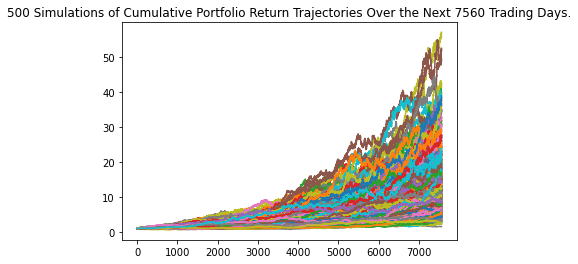

In [232]:
# Plot simulation outcomes
MC_30year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

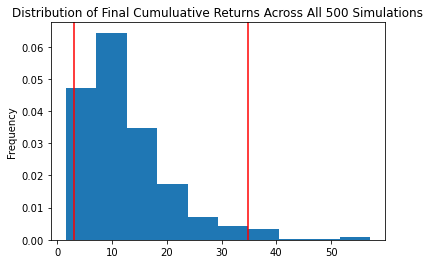

In [233]:
# Plot probability distribution and confidence intervals
MC_30year.plot_distribution()

### Retirement Analysis

In [234]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_30yr_stats = MC_30year.summarize_cumulative_return()

# Print summary statistics
MC_30yr_stats

count           500.000000
mean             12.651825
std               8.177648
min               1.522758
25%               6.946434
50%              10.398254
75%              15.945495
max              57.119453
95% CI Lower      3.028815
95% CI Upper     34.834125
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [235]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_30yr_stats[8]*initial_investment,2)
ci_upper = round(MC_30yr_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $60576.3 and $696682.49


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [236]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_30yr_stats[8]*initial_investment,2)
ci_upper = round(MC_30yr_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $90864.45 and $1045023.74


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [237]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year = MCSimulation(
    portfolio_data = df2_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [238]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/folumccoy/Desktop/Bootcamp/Repo/UTOR-VIRT-FIN-PT-02-2022-U-LOL/Homeworks/05-APIs/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.988690,0.992743,0.995463,0.998568,0.991860,0.987488,1.015911,0.999642,1.000756,0.985941,...,0.998570,1.008564,0.991796,0.991879,0.975992,1.001559,1.007412,0.997932,1.016672,1.001545
2,1.001320,1.003754,0.993449,1.002418,0.994378,0.983369,1.020877,0.984255,1.001847,1.000873,...,1.002590,1.015505,0.993727,0.997739,0.971819,1.016636,1.013394,0.987840,1.016969,1.014344
3,1.017623,1.003291,0.988257,1.003698,1.001686,0.973037,1.008031,0.994767,1.004840,1.002026,...,0.995788,1.020968,1.006981,0.991093,0.967509,1.003219,1.009000,0.993671,1.004319,1.006153
4,1.011916,1.005857,0.988790,1.011540,0.997460,0.964601,1.016370,0.982403,1.007918,1.002256,...,0.993234,1.002177,1.011663,0.992416,0.960633,1.007720,1.017153,0.996208,1.007079,1.006526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.544886,1.353877,2.126160,1.157741,2.010686,1.928906,1.043545,1.383669,2.339065,1.320922,...,1.142556,1.868211,2.154127,1.617282,1.250383,2.222050,1.791674,1.427554,1.601097,1.324988
1257,1.549021,1.342754,2.105879,1.146284,1.981493,1.948871,1.043670,1.382444,2.333534,1.324760,...,1.137782,1.859441,2.178835,1.648069,1.254910,2.196733,1.798280,1.418538,1.606010,1.316471
1258,1.546514,1.325850,2.096049,1.147810,1.961124,1.954405,1.037251,1.385368,2.292474,1.312928,...,1.139397,1.829478,2.189070,1.651878,1.244291,2.219542,1.793030,1.434661,1.588770,1.318384
1259,1.566444,1.334046,2.118986,1.151083,1.963419,1.948738,1.047375,1.393894,2.295335,1.290190,...,1.144714,1.808900,2.226043,1.674554,1.253279,2.207743,1.796302,1.444333,1.596147,1.332304


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

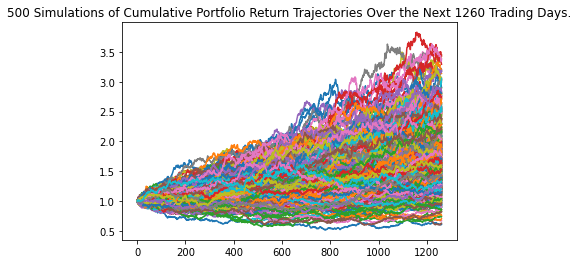

In [239]:
# Plot simulation outcomes
MC_5year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

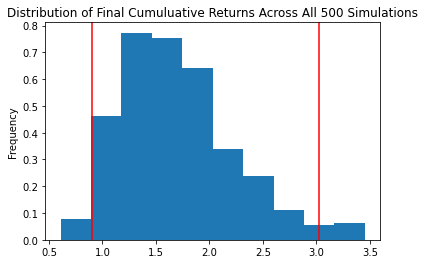

In [240]:
# Plot probability distribution and confidence intervals
MC_5year.plot_distribution()

In [241]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_5yr_stat = MC_5year.summarize_cumulative_return()

# Print summary statistics
MC_5yr_stat

count           500.000000
mean              1.699101
std               0.540324
min               0.607756
25%               1.302052
50%               1.623801
75%               1.991013
max               3.453226
95% CI Lower      0.898100
95% CI Upper      3.028540
Name: 1260, dtype: float64

In [250]:
# Set initial investment
initial_investment = 30000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_five = round(MC_5yr_stat[8]*initial_investment,2)
ci_upper_five = round(MC_5yr_stat[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 5 years will end within in the range of $26943.01 and $90856.2


### Ten Years Retirement Option

In [243]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year = MCSimulation(
    portfolio_data = df2_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [244]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/folumccoy/Desktop/Bootcamp/Repo/UTOR-VIRT-FIN-PT-02-2022-U-LOL/Homeworks/05-APIs/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005994,1.004150,0.996605,1.003879,1.007711,0.990167,0.998554,1.010294,0.990024,1.000189,...,0.995577,1.001328,1.011362,0.997436,1.000340,1.012103,0.992878,1.002017,1.004166,1.010785
2,1.001742,0.996252,1.011084,1.006783,1.010470,0.971764,1.007786,1.000426,0.997311,0.994461,...,0.991039,1.008322,1.002852,0.999417,0.991184,1.006755,0.995334,0.998573,1.009724,1.012203
3,1.007446,1.019657,1.009902,1.029094,0.992802,0.958891,0.999758,0.998809,0.994898,0.993663,...,0.983631,1.004814,1.002729,0.990682,0.985741,1.008625,0.988407,1.010337,1.007956,1.016171
4,1.010024,1.029099,1.008837,1.040453,0.986979,0.966160,1.004394,0.989199,1.002542,0.989894,...,0.976667,1.000522,0.995569,0.997784,0.987156,1.002043,0.998622,1.006214,0.999266,1.010419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.732696,3.844844,2.915322,2.475087,1.390456,4.559578,3.240130,3.712207,2.711665,3.617393,...,4.412658,2.245066,4.344656,1.697663,4.705941,2.238772,1.909384,1.767684,1.875718,1.765775
2517,3.688853,3.870042,2.932474,2.460120,1.395340,4.579178,3.254741,3.713156,2.721002,3.653817,...,4.440962,2.220167,4.304635,1.679819,4.715219,2.225339,1.919509,1.764643,1.900169,1.794875
2518,3.710882,3.893776,2.906451,2.450459,1.394321,4.611960,3.237065,3.710829,2.780710,3.655830,...,4.475138,2.188254,4.356828,1.705179,4.757812,2.223773,1.953326,1.769758,1.874376,1.796053
2519,3.762163,3.906825,2.927352,2.448463,1.382915,4.618317,3.230017,3.701298,2.792960,3.607724,...,4.492721,2.200369,4.362225,1.715725,4.768186,2.219528,1.926495,1.787725,1.884129,1.813845


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

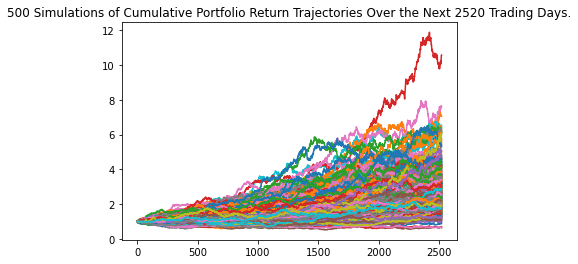

In [245]:
# Plot simulation outcomes
MC_10year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

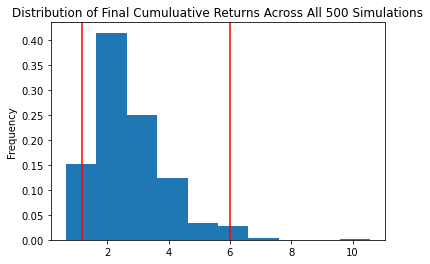

In [246]:
# Plot probability distribution and confidence intervals
MC_10year.plot_distribution()

In [247]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_10yr_stats = MC_10year.summarize_cumulative_return()

# Print summary statistics
MC_10yr_stats

count           500.000000
mean              2.742192
std               1.203844
min               0.650213
25%               1.891206
50%               2.448327
75%               3.388804
max              10.575071
95% CI Lower      1.170281
95% CI Upper      6.012877
Name: 2520, dtype: float64

In [252]:
# Set initial investment
initial_investment = 30000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_ten = round(MC_10yr_stats[8]*initial_investment,2)
ci_upper_ten = round(MC_10yr_stats[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 10 years will end within in the range of $35108.44 and $180386.32
